## Prelimiary Operations

### Manage the directories

In [1]:
# Not important
import os
os.listdir("../input/an2dlhw1bal-dataset/splitted_dataset")

['val', 'test', 'train']

In [2]:
# To delete a folder
import shutil
if os.path.exists("/kaggle/working/andrea"):
    shutil.rmtree("/kaggle/working/andrea")

In [3]:
# to remove a file
import os
if os.path.exists("/kaggle/working/model.png"):
    os.remove("/kaggle/working/model.png")

In [4]:
# to create a folder
import os
directory = "VGG16"
parent_dir = "/kaggle/working"
path = os.path.join(parent_dir, directory)
if not os.path.exists(path):
    os.mkdir(path)

### Operations

In [6]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers

2022-11-14 19:33:00.546050: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [7]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [8]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Importing data

In [9]:
# Dataset folders 
dataset_dir = '/kaggle/input/an2dlhw1bal-dataset/splitted_dataset'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

In [10]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator, and for the trainign with Data Augmentation
train_data_gen = ImageDataGenerator(rotation_range=30,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True, 
                                        fill_mode='reflect',
                                        rescale=1/255.) # Normalization with rescale
valid_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=8,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = train_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)
test_gen = train_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(96,96),
                                              color_mode='rgb',
                                              classes=None, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed)

Found 3432 images belonging to 8 classes.
Found 424 images belonging to 8 classes.
Found 440 images belonging to 8 classes.


## Model

In [12]:
!cd /kaggle/working/VGG16

2022-11-14 19:33:08.336793: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-14 19:33:08.340193: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-14 19:33:08.407876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 19:33:08.408735: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-11-14 19:33:08.408808: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-11-14 19:33:08.437843: I tensorflow/stream_executor/platform/def

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
______________________________________________________________

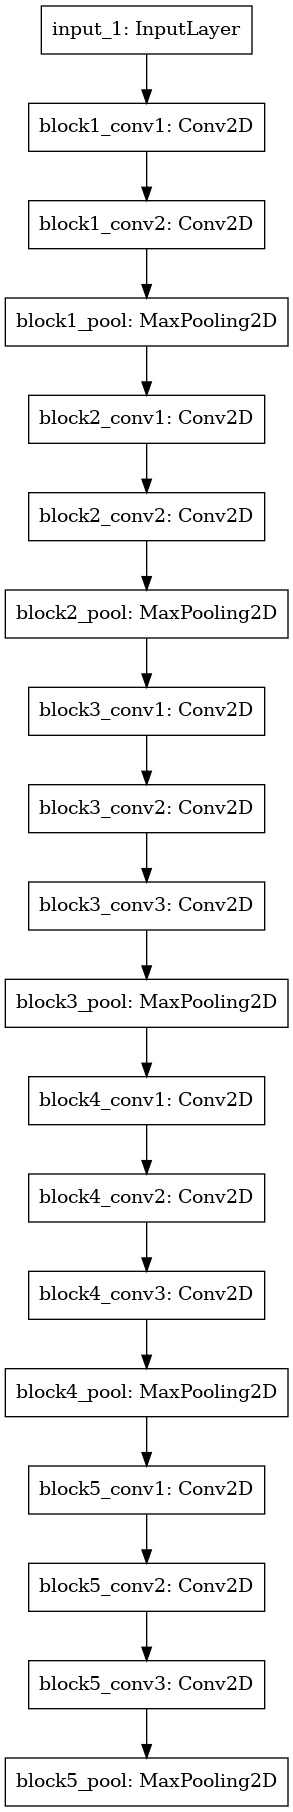

In [13]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [14]:
input_shape = (96, 96, 3)
epochs = 200

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 96, 96, 3)]       0         
_________________________________________________________________
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
Flattening (Flatten)         (None, 4608)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2359808   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 4104  

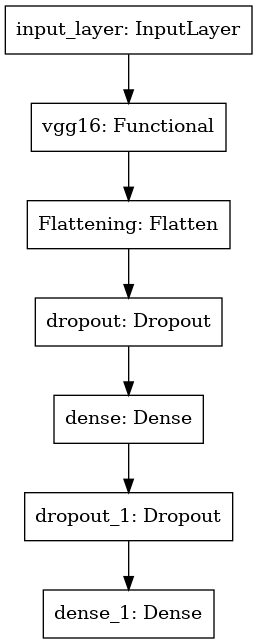

In [15]:
from tensorflow.python.framework.tensor_util import GetNumpyAppendFn

# Use the supernet as feature extractor
supernet.trainable = False
# in this way we keep the weights of the CNN part and we will train only the weights of the classifier

input_layer = tfkl.Input(shape=input_shape, name='input_layer')
x = supernet(input_layer)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    512, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=input_layer, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
tl_model.summary()
tfk.utils.plot_model(tl_model)

## Training

In [16]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('/kaggle/working/VGG16/data_augmentation_experiments_VGG16')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint -> save model after each epoch
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights, false to save the model as we did before af the end of the training
                                                     save_best_only=False) # True to save only the best epoch, false we save each epoch by default
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,# 0 therwise we have some problems in the visualization
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [17]:
# Create folders and callbacks and fit
callbacks = create_folders_and_callbacks(model_name='VGG16')

In [18]:
# Train the model
tl_history = tl_model.fit(
    x = train_gen,
    batch_size = 256,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = callbacks,
    #callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)],
).history

2022-11-14 19:33:13.461926: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-14 19:33:13.465724: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000155000 Hz


Epoch 1/200


2022-11-14 19:33:14.191623: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-11-14 19:33:15.106876: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-11-14 19:33:15.132432: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


429/429 [==============================] - 47s 93ms/step - loss: 2.0318 - accuracy: 0.2980 - val_loss: 1.5418 - val_accuracy: 0.3538
Epoch 2/200
429/429 [==============================] - 17s 39ms/step - loss: 1.5610 - accuracy: 0.3688 - val_loss: 1.3932 - val_accuracy: 0.4599
Epoch 3/200
429/429 [==============================] - 17s 39ms/step - loss: 1.5187 - accuracy: 0.4116 - val_loss: 1.4002 - val_accuracy: 0.4623
Epoch 4/200
429/429 [==============================] - 17s 39ms/step - loss: 1.4121 - accuracy: 0.4655 - val_loss: 1.4221 - val_accuracy: 0.4340
Epoch 5/200
429/429 [==============================] - 16s 38ms/step - loss: 1.4245 - accuracy: 0.4469 - val_loss: 1.4035 - val_accuracy: 0.4552
Epoch 6/200
429/429 [==============================] - 17s 39ms/step - loss: 1.4081 - accuracy: 0.4550 - val_loss: 1.3613 - val_accuracy: 0.4788
Epoch 7/200
429/429 [==============================] - 17s 39ms/step - loss: 1.4089 - accuracy: 0.4529 - val_loss: 1.3450 - val_accuracy: 0.48

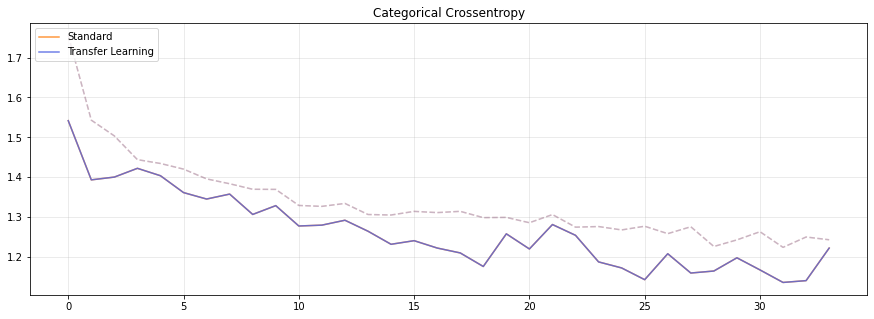

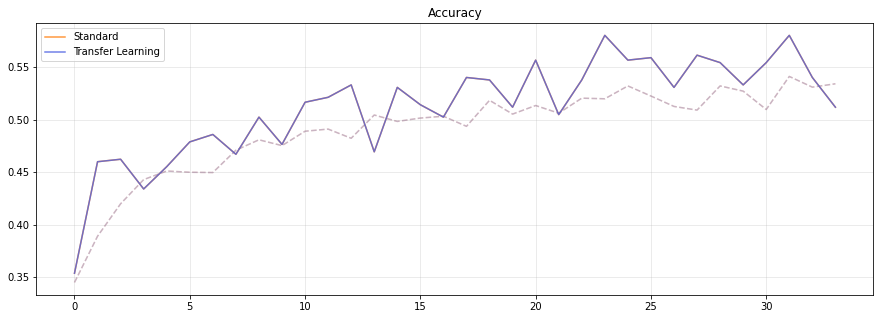

In [19]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(tl_history['val_loss'], label='Standard', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Standard', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [20]:
# Predict the test set with the CNN
predictions = tl_model.predict(test_gen)
predictions.shape

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(test_gen, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(test_gen, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(test_gen, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(test_gen, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(test_gen, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
labels = {
    0:'Species1', 
    1:'Species2', 
    2:'Species3', 
    3:'Species4', 
    4:'Species5', 
    5:'Species6', 
    6:'Species7', 
    7:'Species8'
}
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
# Save the best model
tl_model.save('VGG16_best')
del tl_model